# Homework 4 - Regularization

In [86]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from scipy.stats import uniform

# First we start by loading all the data. This code comes from the sample given in class.

# these two files are large, and it may take a while to read...
counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('data/BicycleWeather.csv', index_col='DATE', parse_dates=True)
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

# add an indicator about Mon - Sun
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

# add an indicator about holiday
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))

# replace missing data with 0
daily['holiday'].fillna(0, inplace=True)

# This function seems crazy. The main goal is to calculate hours of daylight
# https://www.esrl.noaa.gov/gmd/grad/solcalc/sunrise.html here is an example...
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))

# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])
# how='left' means calling frame’s index 
# daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']], how='left', lsuffix='_left', rsuffix='_right')

# number of years passed
daily['annual'] = (daily.index - daily.index[0]).days / 365.

# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']

# Format data into X and Y
X = daily[column_names]
y = daily['Total']

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
Ridge alpha: 0.8916760383807072
Ridge score: 0.7699023884946389
Lasso alpha: 0.8815107114290489
Lasso score: 0.7697365960515639
Linear score: 0.7691752923789884
Best performance: Ridge


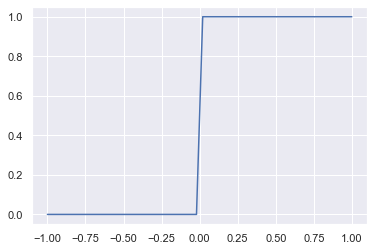

In [97]:
# Now we can compare the models
results = {}

# Ridge
param_grid = {'alpha': uniform(loc=0,scale=1)}

rsearch_ridge = RandomizedSearchCV(estimator=Ridge(), param_distributions=param_grid, cv=10)
rsearch_ridge.fit(X,y)
best_alpha_ridge = rsearch_ridge.best_params_['alpha']
mean_score_ridge = rsearch_ridge.best_score_
print('Ridge alpha: ' + repr(best_alpha_ridge))
print('Ridge score: ' + repr(mean_score_ridge))
results['Ridge'] = mean_score_ridge

# Lasso
rsearch_lasso = RandomizedSearchCV(estimator=Lasso(tol=0.01), param_distributions=param_grid, cv=10)
rsearch_lasso.fit(X,y)
best_alpha_lasso = rsearch_lasso.best_params_['alpha']
mean_score_lasso = rsearch_lasso.best_score_
print('Lasso alpha: ' + repr(best_alpha_lasso))
print('Lasso score: ' + repr(mean_score_lasso))
results['Lasso'] = mean_score_lasso

# Linear Regression
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

linear_cv = cross_val_score(model,X,y,cv=10)
mean_score_linear = linear_cv.mean()
print('Linear score: ' + repr(mean_score_linear))
results['Linear'] = mean_score_linear

max_score = max(results, key=results.get)
print('Best performance: ' + max_score)